### Processing Indian rice yield data
- Objectives: 
    - This notebook ingests and processes rice data obtained from India's APY governmental statistics
    - The data is processed in a manner that accomodates integration with earth observation data prior to building machine learning models

#### Import modules

In [1]:
# import modules
import pandas as pd
import openpyxl
import numpy as np
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import geopandas as gpd
import matplotlib.pyplot as plt
import geopandas as gpd
import scipy
import matplotlib.gridspec as gridspec

In [4]:
# Import India yield data
datafile = r'C:\Users\djava\OneDrive\Documents\Oxford\Projects\india_rice_early_warning\4_data\RAW_DATA\INDIA_RICE_YIELDS\rice_yield.xlsx'

# import the shapefile
geo_df = gpd.read_file(r'C:\Users\djava\OneDrive\Documents\Oxford\Projects\india_rice_early_warning\4_data\RAW_DATA\SHAPEFILE\gadm36_IND_2.shp')

#### Clean raw India yield data

In [5]:
def clean_india_yield_data(datafile):
    """
    Clean rice yield data downloaded from the APY website.
    
    Args:
        datafile (str): Path to the Excel file.
        
    Returns:
        pandas.DataFrame: A dataframe with distinct values from the "State" and "District" columns.
    """
    # Read Excel file into a pandas dataframe and skip the first 2 rows
    df = pd.read_excel(datafile, sheet_name='APY1_Public', skiprows=2)
    
    # Rename the first column to "State"
    df.rename(columns={df.columns[0]: 'State'}, inplace=True)
    
    # Forward fill the "State" column
    df['State'] = df['State'].fillna(method='ffill')
    
    # Forward fill the "Year" column
    df['Year'] = df['Year'].fillna(method='ffill')
    
    # Drop rows that have "Rice" or "Total - Rice" as values in the "State" column
    df = df.query('State != "Rice" and State != "Total - Rice" and State != " "')
    
    # Rename the "State" column to "District"
    df.rename(columns={'State': 'District'}, inplace=True)
    
    # Query for rows that do not contain any numbers in the "District" column
    states_df = df[~df['District'].str.contains(r'\d')]
    
    # Keep only the "District" column in states_df
    states_df = states_df[['District']]
    
    # Join states_df and df on the "District" column
    df = df.join(states_df, lsuffix='_df', rsuffix='_states_df')
    
    # Forward fill the "District_states_df" column
    df['District_states_df'] = df['District_states_df'].fillna(method='ffill')
    
    # Drop rows that contain NaN values
    df = df.dropna()
    
    # Rename the columns
    df.rename(columns={'District_states_df': 'State', 'District_df': 'District'}, inplace=True)
    
    # Strip blank spaces from the "Year" column
    df['Year'] = df['Year'].str.strip()
    
    # Strip leading spaces from the "District" column
    df['District'] = df['District'].str.lstrip()
    
    # Strip leading and trailing blanks from the "Season" column
    df['Season'] = df['Season'].str.strip()
    
    # Remove numbers and "." from the "District" column
    df['District'] = df['District'].str.replace(r'\d+|\.', '')
    
    return df

In [6]:
cleaned_india_data = clean_india_yield_data(datafile)

C:\Users\djava\AppData\Local\Temp\ipykernel_5548\1642487185.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'State': 'District'}, inplace=True)
C:\Users\djava\AppData\Local\Temp\ipykernel_5548\1642487185.py:57: FutureWarning: The default value of regex will change from True to False in a future version.
  df['District'] = df['District'].str.replace(r'\d+|\.', '')


In [9]:
cleaned_india_data.sample(10)

,District,Year,Season,Area (Hectare),Production (Tonnes),Yield (Tonnes/Hectare),State
24865,SHAHJAHANPUR,1998-99,Kharif,171346.00,379215.0,2.213154,Uttar Pradesh
15936,CHURACHANDPUR,2005-06,Kharif,20370.00,37500.0,1.840943,Manipur
25975,COOCHBEHAR,1999-00,Total,292252.00,439770.0,1.504763,West Bengal
18262,JAGATSINGHAPUR,2011-12,Total,81000.00,195000.0,2.407407,Odisha
6613,SITAMARHI,2004-05,Autumn,22121.00,19525.0,0.882645,Bihar
10185,SARAIKELA KHARSAWAN,2006-07,Autumn,1091.45,632.0,0.579046,Jharkhand
16757,AIZAWL,2015-16,Kharif,875.00,2100.0,2.400000,Mizoram
19189,NAYAGARH,2016-17,Total,91690.00,209550.0,2.285418,Odisha
10665,BIDAR,2005-06,Kharif,7436.00,4059.0,0.545858,Karnataka
10410,BALLARI,2016-17,Summer,3417.00,9443.0,2.763535,Karnataka


## Fuzzy matching

In [10]:
def fuzzy_match_states_districts(geo_df):
    """
    Perform fuzzy matching between state and district names in two dataframes.

    Args:
        geo_df (DataFrame): DataFrame containing geographical information.
        df1 (DataFrame): First DataFrame for fuzzy matching.
        cleaned_india_data (DataFrame): Second DataFrame for fuzzy matching.

    Returns:
        DataFrame: Resulting DataFrame with matched state-district pairs and match scores.
    """
    # rename the columns to State and District
    geo_df.rename(columns={'NAME_1':'State', 'NAME_2':'District'}, inplace=True)

    # concatenate the State and District columns in both dataframes with a space between them
    geo_df['State_District'] = geo_df['State'] + ' ' + geo_df['District']

    # only keep the columns State, District, GID_2, State_District, and geometry
    geo_df = geo_df[['State', 'District', 'GID_2', 'State_District', 'geometry']]
    # concatenate the State and District columns in both dataframes with a space between them
    geo_df['State_District'] = geo_df['State'] + ' ' + geo_df['District']
    # make a copy of the geo_df for fuzzy matching
    df1 = geo_df[['State', 'District', 'State_District']].copy()
    # prepare the India yield data for fuzzy matching
    df2 = cleaned_india_data[['State', 'District']].drop_duplicates().copy()

    # concatenate the State and District columns in both dataframes with a space between them
    df2['State_District'] = df2['State'] + ' ' + df2['District']
    
    # run fuzzy matching algorithm
    result_df = pd.DataFrame(columns=['df1_State_District', 'df2_State_District', 'Match_Score'])

    for _, row in df1.iterrows():
        state_district = row['State_District']
        match = process.extractOne(state_district, df2['State_District'])
        if match and match[1] >= 90:
            df1_state_district = state_district
            df2_state_district = df2.loc[match[2], 'State_District']
            match_score = match[1]
            result_df = result_df.append({'df1_State_District': df1_state_district,
                                        'df2_State_District': df2_state_district,
                                        'Match_Score': match_score},
                                        ignore_index=True)

    # Query results df to remove: Rajasthan Barmer, Jammu and Kashmir Kargil, Jammu and Kashmir Leh (Ladakh), Jammu and Kashmir Rajouri, Jammu and Kashmir Shupiyan, Puducherry Puducherry
    result_df = result_df.query('df1_State_District != "Rajasthan Barmer" and df1_State_District != "Jammu and Kashmir Kargil" and df1_State_District != "Jammu and Kashmir Leh (Ladakh)" and df1_State_District != "Jammu and Kashmir Rajouri" and df1_State_District != "Jammu and Kashmir Shupiyan" and df1_State_District != "Puducherry Puducherry"')

    return result_df

In [11]:
result_df = fuzzy_match_states_districts(geo_df)

c:\Users\djava\miniconda3\envs\xarray_test\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
C:\Users\djava\AppData\Local\Temp\ipykernel_5548\700338351.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'df1_State_District': df1_state_district,
C:\Users\djava\AppData\Local\Temp\ipykernel_5548\700338351.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'df1_State_District': df1_state_district,
C:\Users\djava\AppDat

In [12]:
result_df

,df1_State_District,df2_State_District,Match_Score
0,Andaman and Nicobar Nicobar Islands,Andaman and Nicobar Islands NICOBARS,95
1,Andaman and Nicobar North and Middle Andaman,Andaman and Nicobar Islands NORTH AND MIDDLE A...,95
2,Andaman and Nicobar South Andaman,Andaman and Nicobar Islands SOUTH ANDAMANS,95
3,Andhra Pradesh Anantapur,Andhra Pradesh ANANTAPUR,100
4,Andhra Pradesh Chittoor,Andhra Pradesh CHITTOOR,100
...,...,...,...
616,West Bengal Nadia,West Bengal NADIA,100
617,West Bengal Pashchim Medinipur,West Bengal MEDINIPUR WEST,95
618,West Bengal Purba Medinipur,West Bengal MEDINIPUR WEST,95
619,West Bengal Puruliya,West Bengal PURULIA,97


#### Merge India yield data with geodataframe

In [13]:
def join_data_with_geography(geo_df, result_df, cleaned_india_data):
    """
    Join geographical data with matched data based on state and district names.

    Args:
        geo_df (DataFrame): DataFrame containing geographical information.
        result_df (DataFrame): DataFrame with matched state-district pairs and match scores.
        cleaned_india_data (DataFrame): DataFrame containing cleaned India data.

    Returns:
        DataFrame: Resulting DataFrame with joined data based on state and district names.
    """
    # Join the geo_df and result_df on the State_District column
    geo_df_joined = geo_df.join(result_df.set_index('df1_State_District'), on='State_District')

    # Keep State, District, GID_2, df2_State_District columns
    geo_df_joined = geo_df_joined[['State', 'District', 'GID_2', 'df2_State_District']]

    # Add back the column to join the cleaned_india_data dataframe with the geo_df_joined dataframe
    cleaned_india_data['State_District'] = cleaned_india_data['State'] + ' ' + cleaned_india_data['District']

    # Perform a left join on the geo_df_joined dataframe (left) and cleaned_india_data dataframe (right)
    merged_geo_df = geo_df_joined.merge(cleaned_india_data, how='left', left_on='df2_State_District', right_on='State_District')

    # Keep the desired columns
    india_data_geo_key = merged_geo_df[['GID_2', 'State_x', 'District_x', 'Year', 'Season', 'Area (Hectare)', 'Production (Tonnes)', 'Yield (Tonnes/Hectare)']].copy()
    
    # Rename columns
    india_data_geo_key.rename(columns={'State_x': 'State', 'District_x': 'District'}, inplace=True)

    # keep the first four characters of the year column
    india_data_geo_key['Year'] = india_data_geo_key['Year'].str[:4]
    
    # Make a new column with year+1, ignoring NaN values, and convert back to text
    india_data_geo_key['Year End'] = pd.to_numeric(india_data_geo_key['Year'], errors='coerce') + 1
    
    # Convert year+1 back to text without the decimal, ignoring nan values
    india_data_geo_key['Year End'] = india_data_geo_key['Year End'].astype(str).str[:-2]
    
    # Reorder columns to have Year End after Year
    india_data_geo_key = india_data_geo_key[['GID_2', 'State', 'District', 'Year', 'Year End', 'Season', 'Area (Hectare)', 'Production (Tonnes)', 'Yield (Tonnes/Hectare)']]

    return india_data_geo_key

In [14]:
india_data_geo_key = join_data_with_geography(geo_df, result_df, cleaned_india_data)

In [15]:
india_data_geo_key

,GID_2,State,District,Year,Year End,Season,Area (Hectare),Production (Tonnes),Yield (Tonnes/Hectare)
0,IND.1.1_1,Andaman and Nicobar,Nicobar Islands,2000,2001,Kharif,102.00,321.00,3.147059
1,IND.1.1_1,Andaman and Nicobar,Nicobar Islands,2001,2002,Kharif,83.00,300.00,3.614458
2,IND.1.1_1,Andaman and Nicobar,Nicobar Islands,2002,2003,Kharif,189.20,510.84,2.700000
3,IND.1.1_1,Andaman and Nicobar,Nicobar Islands,2003,2004,Kharif,52.00,90.17,1.734038
4,IND.1.1_1,Andaman and Nicobar,Nicobar Islands,2004,2005,Kharif,52.94,72.57,1.370797
...,...,...,...,...,...,...,...,...,...
24695,IND.36.20_1,West Bengal,Uttar Dinajpur,2018,2019,Total,221257.00,646243.00,2.920780
24696,IND.36.20_1,West Bengal,Uttar Dinajpur,2019,2020,Autumn,2251.00,6021.00,2.674811
24697,IND.36.20_1,West Bengal,Uttar Dinajpur,2019,2020,Summer,47166.00,152694.00,3.237374
24698,IND.36.20_1,West Bengal,Uttar Dinajpur,2019,2020,Winter,181689.00,554568.00,3.052293


### Prepare df for machine learning (keep kharif only, keep relevant years, remove outliers)

In [16]:
def clean_india_data(india_data_geo_key):
    """
    Cleans the India data by converting the 'Year' column to integer,
    keeping only the 'Kharif' season, and removing outliers based on yield.

    Parameters:
    - india_data_geo_key (pandas.DataFrame): DataFrame containing the India data

    Returns:
    - india_data_cleaned (pandas.DataFrame): Cleaned DataFrame with outliers removed
    """
    # Convert 'Year' column to integer and ignore NaN values
    india_data_geo_key['Year'] = pd.to_numeric(india_data_geo_key['Year'], errors='coerce')

    # Keep 'Kharif' Season only
    india_data_geo_key = india_data_geo_key.query('Season == "Kharif"')

    def remove_outliers(group):
        """
        Removes outliers from a group based on the 'Yield (Tonnes/Hectare)' column using IQR method.

        Parameters:
        - group (pandas.DataFrame): Grouped DataFrame

        Returns:
        - group_no_outliers (pandas.DataFrame): DataFrame with outliers removed
        """
        Q1 = group['Yield (Tonnes/Hectare)'].quantile(0.10)
        Q3 = group['Yield (Tonnes/Hectare)'].quantile(0.90)
        IQR = Q3 - Q1
        is_outlier = ((group['Yield (Tonnes/Hectare)'] < (Q1 - 1.5 * IQR)) | (group['Yield (Tonnes/Hectare)'] > (Q3 + 1.5 * IQR)))
        return group[~is_outlier]

    # Group by 'State' and 'District', then apply the function to remove outliers
    india_data_cleaned = india_data_geo_key.groupby(['State', 'District']).apply(remove_outliers).reset_index(drop=True)

    return india_data_cleaned


In [17]:
india_data_geo_key_no_outliers = clean_india_data(india_data_geo_key)

In [18]:
# query dataframe for punjab
india_data_geo_key_no_outliers

,GID_2,State,District,Year,Year End,Season,Area (Hectare),Production (Tonnes),Yield (Tonnes/Hectare)
0,IND.1.1_1,Andaman and Nicobar,Nicobar Islands,2000.0,2001,Kharif,102.00,321.00,3.147059
1,IND.1.1_1,Andaman and Nicobar,Nicobar Islands,2001.0,2002,Kharif,83.00,300.00,3.614458
2,IND.1.1_1,Andaman and Nicobar,Nicobar Islands,2002.0,2003,Kharif,189.20,510.84,2.700000
3,IND.1.1_1,Andaman and Nicobar,Nicobar Islands,2003.0,2004,Kharif,52.00,90.17,1.734038
4,IND.1.1_1,Andaman and Nicobar,Nicobar Islands,2004.0,2005,Kharif,52.94,72.57,1.370797
...,...,...,...,...,...,...,...,...,...
9030,IND.35.13_1,Uttarakhand,Uttarkashi,2016.0,2017,Kharif,10107.00,17888.00,1.769862
9031,IND.35.13_1,Uttarakhand,Uttarkashi,2017.0,2018,Kharif,10249.00,17572.00,1.714509
9032,IND.35.13_1,Uttarakhand,Uttarkashi,2018.0,2019,Kharif,10174.00,16552.00,1.626892
9033,IND.35.13_1,Uttarakhand,Uttarkashi,2019.0,2020,Kharif,10820.00,18148.00,1.677264


In [19]:
def filter_consecutive_years(india_data_geo_key_no_outliers):
    """
    Filters the India data to keep only the entries with at least 18 consecutive years of data starting from the year 2000 or later.

    Parameters:
    - india_data_geo_key_no_outliers (pandas.DataFrame): DataFrame containing the cleaned India data with outliers removed

    Returns:
    - filtered_df (pandas.DataFrame): DataFrame with entries having at least 18 consecutive years of data
    """
    # Filter rows where 'Year' is greater than or equal to 2000
    india_data_filtered = india_data_geo_key_no_outliers[india_data_geo_key_no_outliers['Year'] >= 2000]

    # Sort the DataFrame first by 'GID_2', then by 'Year'
    df_sorted = india_data_filtered.sort_values(["GID_2", "Year"])

    # Create a new column 'consecutive_year' that marks consecutive years within each 'GID_2'
    df_sorted['consecutive_year'] = df_sorted.groupby('GID_2')['Year'].diff().eq(1).astype(int)

    # Create a new column 'consecutive_year_cumsum' that calculates the cumulative sum of 'consecutive_year' for each 'GID_2'
    df_sorted['consecutive_year_cumsum'] = df_sorted.groupby(['GID_2', df_sorted.consecutive_year.ne(df_sorted.consecutive_year.shift()).cumsum()])['consecutive_year'].cumsum()

    # Filter the DataFrame to keep only the rows with at least 18 consecutive years of data within each 'GID_2'
    filtered_df = df_sorted[df_sorted.groupby('GID_2')['consecutive_year_cumsum'].transform(max) >= 17]

    # Drop the columns 'consecutive_year' and 'consecutive_year_cumsum' since they are no longer needed.
    filtered_df = filtered_df.drop(columns=['consecutive_year', 'consecutive_year_cumsum'])

    # Make the Year and Year_End columns integers
    filtered_df['Year'] = filtered_df['Year'].astype(int)
    filtered_df['Year End'] = filtered_df['Year End'].astype(int)

    return filtered_df

In [20]:
# Prepare final df
final_india_yield_df =  filter_consecutive_years(india_data_geo_key_no_outliers)

In [21]:
final_india_yield_df

,GID_2,State,District,Year,Year End,Season,Area (Hectare),Production (Tonnes),Yield (Tonnes/Hectare)
1306,IND.11.12_1,Gujarat,Gandhinagar,2000,2001,Kharif,7600.0,17100.0,2.250000
1307,IND.11.12_1,Gujarat,Gandhinagar,2001,2002,Kharif,7000.0,17500.0,2.500000
1308,IND.11.12_1,Gujarat,Gandhinagar,2002,2003,Kharif,4600.0,9900.0,2.152174
1309,IND.11.12_1,Gujarat,Gandhinagar,2003,2004,Kharif,13100.0,35200.0,2.687023
1310,IND.11.12_1,Gujarat,Gandhinagar,2004,2005,Kharif,13200.0,29100.0,2.204545
...,...,...,...,...,...,...,...,...,...
890,IND.7.9_1,Chhattisgarh,Dhamtari,2015,2016,Kharif,173361.0,314275.0,1.812836
891,IND.7.9_1,Chhattisgarh,Dhamtari,2016,2017,Kharif,183504.0,603476.0,3.288626
892,IND.7.9_1,Chhattisgarh,Dhamtari,2017,2018,Kharif,144868.0,311175.0,2.147990
893,IND.7.9_1,Chhattisgarh,Dhamtari,2018,2019,Kharif,178763.0,433106.0,2.422794


In [25]:
# Save this dataframe to PROCESSED_DATA\processed_yield
final_india_yield_df.to_csv(r'C:\Users\djava\OneDrive\Documents\Oxford\Projects\india_rice_early_warning\4_data\PROCESSED_DATA\YIELD\india_processed_yield.csv', index=False)

# Save to excel


In [ ]:
# save to excel



### Visualize data to validate dataframe

In [22]:
# In geo_df, only keep GID_2 and geometry columns
geo_df = geo_df[['GID_2', 'geometry']]

c:\Users\djava\miniconda3\envs\xarray_test\lib\site-packages\geopandas\plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
c:\Users\djava\miniconda3\envs\xarray_test\lib\site-packages\geopandas\plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
c:\Users\djava\miniconda3\envs\xarray_test\lib\site-packages\geopandas\plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
c:\Users\djava\miniconda3\envs\xarray_test\lib\site-packages\geopandas

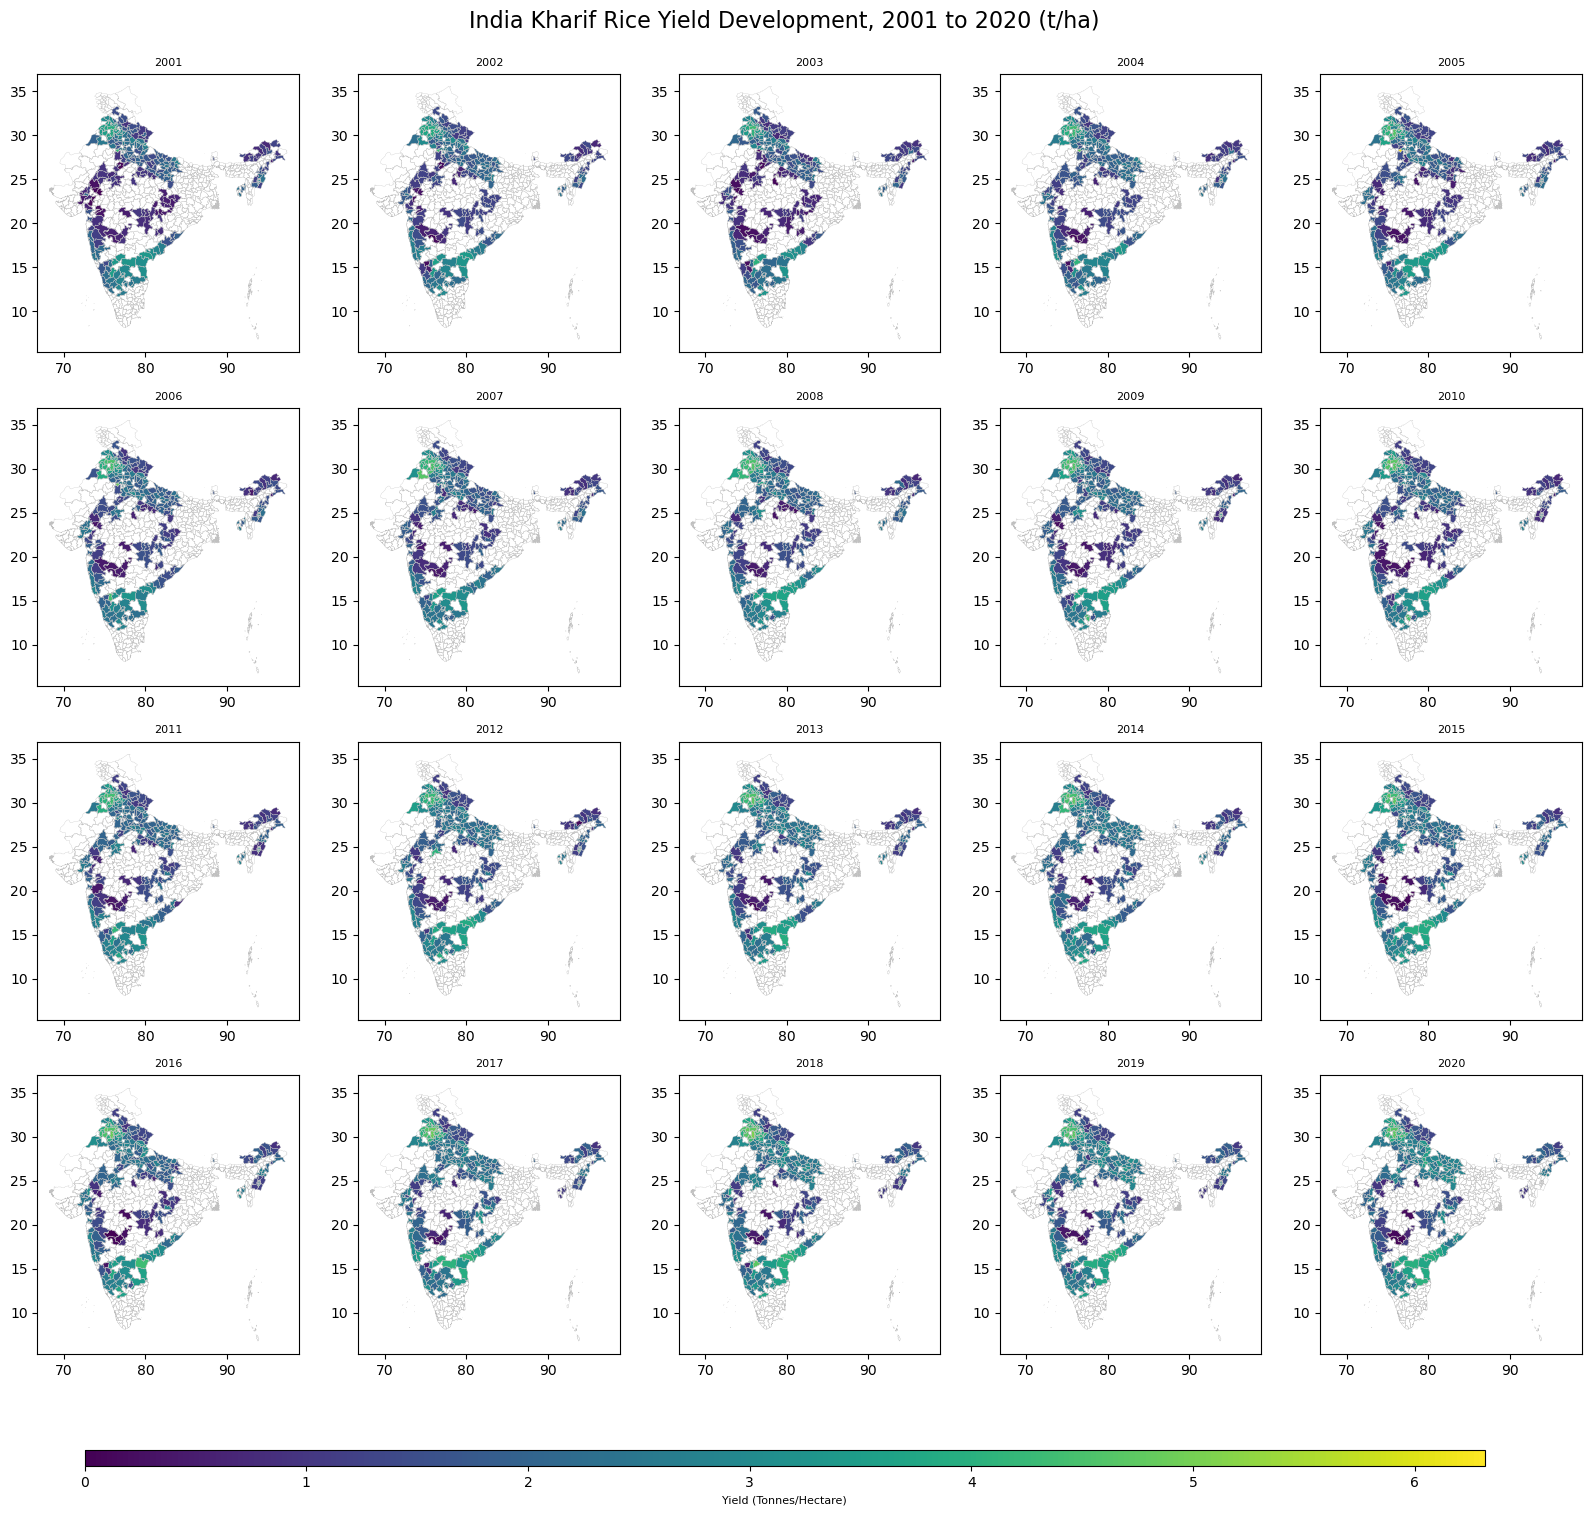

In [23]:
# Get list of unique years and remove the final year (2020)
years = final_india_yield_df['Year'].unique()
years = years[years != 2020]

# Number of rows and columns for the plot grid
nrows = int(np.ceil(len(years) / 5))  # adjusting to 5 columns for visualization
ncols = 5

# Create a subplot grid
fig = plt.figure(figsize=(20, nrows*4))  # reduced figure size
gs = gridspec.GridSpec(nrows, ncols, figure=fig, wspace=0.2, hspace=0.2)  # less whitespace

# Use a single colorbar for all subplots
vmin = final_india_yield_df['Yield (Tonnes/Hectare)'].min()
vmax = final_india_yield_df['Yield (Tonnes/Hectare)'].max()
cmap = 'viridis'  # Or another colormap that you like
norm = plt.Normalize(vmin=vmin, vmax=vmax)

for i, year in enumerate(years):
    ax = fig.add_subplot(gs[i])

    # First, plot all the geometries with a very light grey edge color and white fill color
    geo_df.boundary.plot(color=None, edgecolor='silver', linewidth=0.2, ax=ax)  # thinner lines

    # Merge dataframes for this year
    data_year = final_india_yield_df[final_india_yield_df['Year'] == year]
    merged = geo_df.merge(data_year, on='GID_2', how='left')

    # Plot data
    merged.dropna(subset=['Yield (Tonnes/Hectare)']).plot(column='Yield (Tonnes/Hectare)', ax=ax, legend=False, cmap=cmap, norm=norm)

    ax.set_title(f"{year+1}", fontsize=8)  # smaller font size

# Add a single colorbar at the bottom
fig.subplots_adjust(bottom=0.08, hspace=0.5)  # more space for colorbar
cbar_ax = fig.add_axes([0.15, 0.01, 0.7, 0.01])  # lower colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Yield (Tonnes/Hectare)', size=8)  # smaller label for the colorbar

# Set an overall title for the grid of plots
fig.suptitle('India Kharif Rice Yield Development, 2001 to 2020 (t/ha)', fontsize=16, y=0.92)  # adjust y to place title correctly

plt.show()
